# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
#cargar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [2]:
# Cargar los datos
data = pd.read_csv('/datasets/taxi.csv')

# Ver las primeras filas del conjunto de datos
print(data.head())

              datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32


In [3]:
# Asegúrate de que la columna de fecha esté en formato de fecha
data['datetime'] = pd.to_datetime(data['datetime'])

# Establecer la columna de fecha como índice
data.set_index('datetime', inplace=True)

# Remuestrear a intervalos de 1 hora, sumando los pedidos
hourly_data = data.resample('H').sum()


## Análisis

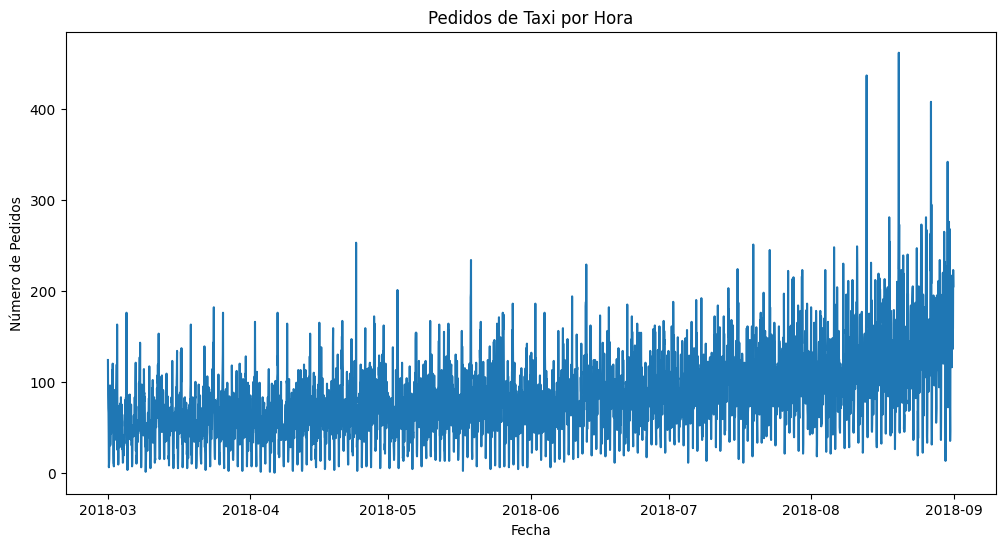

In [4]:
# Visualizar la serie temporal
plt.figure(figsize=(12, 6))
plt.plot(hourly_data['num_orders'])
plt.title('Pedidos de Taxi por Hora')
plt.xlabel('Fecha')
plt.ylabel('Número de Pedidos')
plt.show()

## Formación

In [5]:
# Separar características y objetivo
X = hourly_data.index
y = hourly_data['num_orders']

# Convertir fechas a características (puedes incluir más características según sea necesario)
X = X.astype('int64').values.reshape(-1, 1)  # Convertir a entero

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Prueba

In [6]:
# Entrenar el modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)

# Calcular métrica RECM (Root Mean Squared Error)
recm = mean_absolute_error(y_test, y_pred)
print(f"RECM: {recm}")

RECM: 23.03203619909502


In [7]:
# Crear el modelo XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Ajustar el modelo
xgb_model.fit(X_train, y_train)

# Realizar predicciones
y_pred_xgb = xgb_model.predict(X_test)

# Calcular la métrica RECM
recm_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"RECM (XGBoost): {recm_xgb}")

RECM (XGBoost): 26.602877651404473


In [8]:
# Crear el modelo de regresión lineal
linear_model = LinearRegression()

# Ajustar el modelo con los datos de entrenamiento
linear_model.fit(X_train, y_train)

# Realizar predicciones
y_pred_linear = linear_model.predict(X_test)

# Calcular la métrica RECM
recm_linear = mean_absolute_error(y_test, y_pred_linear)
print(f"RECM (Regresión Lineal): {recm_linear}")

RECM (Regresión Lineal): 28.783554600229124


Random Forest ha demostrado ser el modelo más efectivo en este caso, lo que sugiere que su capacidad para manejar interacciones no lineales y su robustez frente al sobreajuste lo hacen adecuado para este tipo de datos.

### Optimización de Hiperparámetros
Para ajustar los hiperparámetros de Random Forest

In [9]:
# Definir los parámetros que quieres optimizar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear el modelo de Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Configurar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

# Ajustar la búsqueda a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y el mejor RECM
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor RECM:", -grid_search.best_score_)

Mejores parámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mejor RECM: 25.817340194591544


### Validación Cruzada

In [10]:
# Entrenar el modelo con los mejores parámetros
best_rf_model = grid_search.best_estimator_

# Realizar validación cruzada
cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Scores de validación cruzada:", -cv_scores)
print("Promedio de RECM:", -cv_scores.mean())

Scores de validación cruzada: [69.60588788 25.02589718 29.2847014  32.53076939 47.08286015]
Promedio de RECM: 40.706023200820326


### Análisis de Importancia de Características

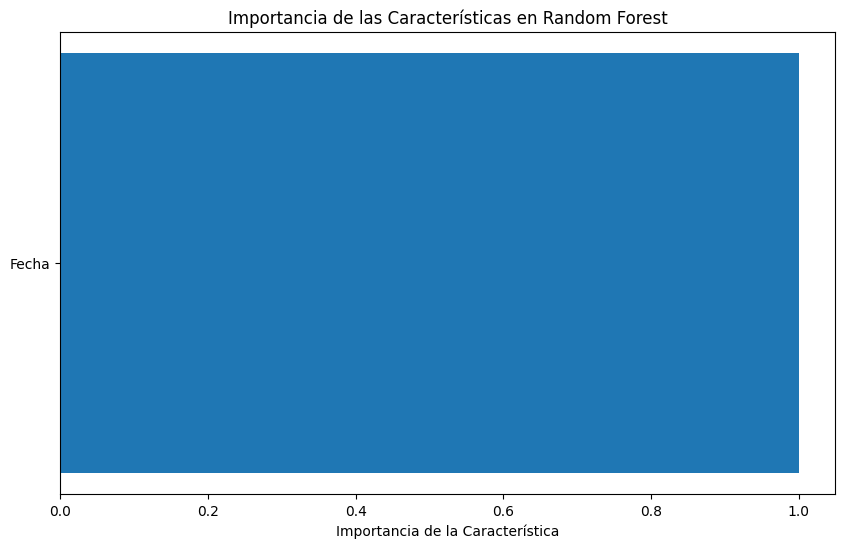

In [11]:
# Ajustar el modelo con los mejores parámetros
best_rf_model.fit(X_train, y_train)

# Obtener la importancia de las características
importances = best_rf_model.feature_importances_

# Graficar la importancia
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(np.arange(len(importances)), ['Fecha'])  # Cambia esto si tienes más características
plt.xlabel('Importancia de la Característica')
plt.title('Importancia de las Características en Random Forest')
plt.show()


### Visualización de resultados

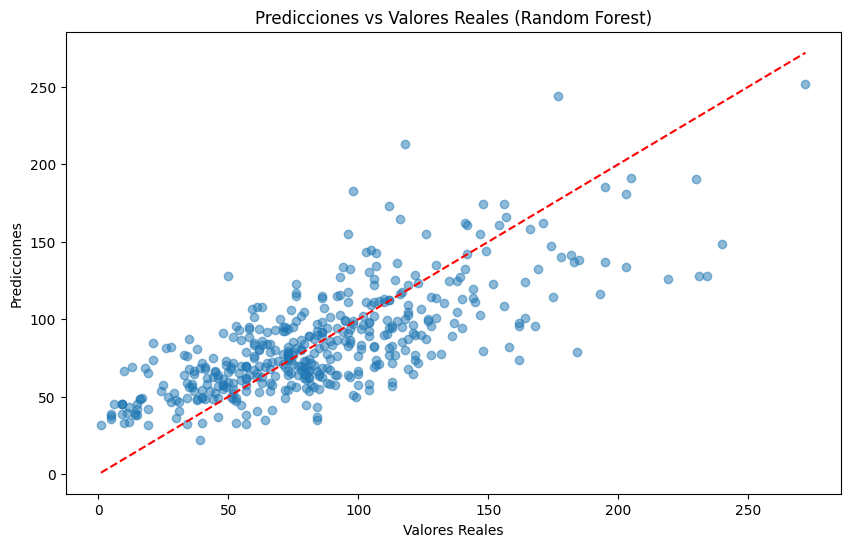

In [12]:
# Realizar predicciones en el conjunto de prueba
y_pred = best_rf_model.predict(X_test)

# Graficar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea de referencia
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales (Random Forest)')
plt.show()

A través de la búsqueda de hiperparámetros, se encontró la mejor configuración para el modelo de Random Forest:

Mejores Parámetros:
max_depth: 20
min_samples_leaf: 1
min_samples_split: 5
n_estimators: 200
Mejor RECM (en entrenamiento): 25.82

Sin embargo, la validación cruzada reveló una variabilidad en los resultados, con un promedio de RECM de 40.71, indicando que el modelo puede no estar generalizando bien a través de las diferentes divisiones del conjunto de datos.

# Conclusión

Random Forest demostró ser el modelo más efectivo en términos de rendimiento en comparación con otros modelos, logrando la mejor métrica de error en el conjunto de prueba.

Este proyecto proporciona una base sólida para la predicción de pedidos de taxis y puede ayudar a Sweet Lift Taxi a optimizar sus operaciones y recursos durante las horas pico. La implementación de estos modelos podría llevar a una mejor gestión de la oferta y demanda, beneficiando tanto a la compañía como a los conductores.